In [2]:

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig
)
from sklearn.metrics import accuracy_score

In [2]:
from transformers import pipeline
from transformers import TextClassificationPipeline
# Load the tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("/content/drive/MyDrive/Marcus_Project/removed_n/model",  model_max_length = 512)
model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/Marcus_Project/removed_n/model")
#classifier = pipeline('text-classification',"/content/drive/MyDrive/Marcus_Project/removed_n/model")
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    top_k=1,
    truncation=True,  # Ensures that input sequences are truncated
    padding=True      # Pads sequences to the maximum length
)


##Testing ML dataset without finetuning

In [5]:
import json

test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/ml_dataset/arxiv_papers_with_MT_llama_test.jsonl"
# Load datasets
# Read JSONL data into a list
with open(test_data_path, "r") as file:
    test_data = [json.loads(line.strip()) for line in file]

# Collect unique keys
unique_keys = set()
for json_obj in test_data:
    unique_keys.update(json_obj.keys())

# Print unique keys
print("Keys in the JSONL file:", list(unique_keys))


Keys in the JSONL file: ['archive_size', 'Abstract', 'arxiv_id', 'machine_text', 'tables', 'sections', 'Prompt', 'title']


In [1]:
!pip install transformers datasets huggingface_hub tensorboard==2.11
!sudo apt-get install git-lfs --yes


import json
import torch
from datasets import load_dataset
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer
from huggingface_hub import HfFolder, notebook_login
! pip install transformers[torch] -U
! pip install accelerate -U


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
from datasets import Dataset

def prepare_dataset(data, abstract = "human_text", machine_abstract = "machine_text"):
    examples = []
    labels = []

    # Append text and labels for human and machine texts
    for example in data:
        examples.append(example[abstract])
        labels.append(0)  # Human text label
        examples.append(example[machine_abstract])
        labels.append(1)  # Machine text label

    # Creating a dataset
    dataset = Dataset.from_dict({"text": examples, "labels": labels})
    return dataset


In [12]:
llma_test_data = prepare_dataset(test_data, abstract = 'Abstract', machine_abstract = 'machine_text')
print("Size of the dataset:", len(llma_test_data))


Size of the dataset: 1200


In [13]:
# Make predictions
# predictions = pipeline(test_dataset["text"])

# Define classification function
def classify_text(example):
    try:
        predictions = classifier(example['text'])
        return {'predicted_labels': predictions[0][0]['label']}
    except Exception as e:
        #print(f"Error processing example: {example['text']}")
        print(e)
        return {'predicted_labels': None}



In [15]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
llma_test_data = llma_test_data.map(classify_text, batched=False)
# Check the first few entries to verify


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [17]:
print(llma_test_data[0])

{'text': 'A new multiscale implementation of non-local means filtering for image denoising is proposed. The proposed algorithm also introduces a modification of similarity measure for patch comparison. The standard Euclidean norm is replaced by weighted Euclidean norm for patch based comparison. Assuming the patch as an oriented surface, notion of normal vector patch is being associated with each patch. The inner product of these normal vector patches is then used in weighted Euclidean distance of photometric patches as the weight factor. The algorithm involves two steps: The first step is multiscale implementation of an accelerated non-local means filtering in the stationary wavelet domain to obtain a refined version of the noisy patches for later comparison. This step is inspired by a preselection phase of finding similar patches in various non-local means approaches. The next step is to apply the modified non-local means filtering to the noisy image using the reference patches obtai

In [16]:
df_test_dataset_llma = llma_test_data.to_pandas()
df_test_dataset_llma['target_labels'] = df_test_dataset_llma['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


In [21]:
import pandas as pd
# Replace None with NaN for proper handling by dropna
df_test_dataset_llma['predicted_labels'].replace({None: pd.NA}, inplace=True)

# Drop rows where 'predicted_labels' is None (NaN)
df_test_dataset_llma = df_test_dataset_llma.dropna(subset=['predicted_labels'])


In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Unique values in predicted_labels: {'human-produced', 'machine-generated'}
Unique values in true_labels: {'human-produced', 'machine-generated'}
Confusion Matrix in Percentage:
[[12.33333333 87.66666667]
 [81.16666667 18.83333333]]


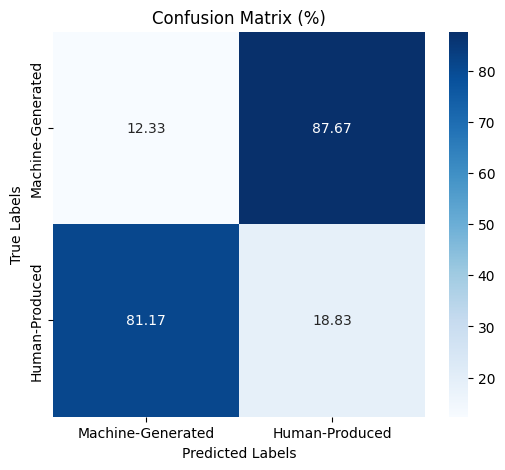

In [23]:
predicted_labels = df_test_dataset_llma.predicted_labels.to_list()
true_labels = df_test_dataset_llma.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()


##Finetuning the model with ML dataset

In [4]:
with open("/content/drive/MyDrive/Marcus_Project/removed_n/ml_dataset/arxiv_papers_with_MT_llama_train.jsonl", "r") as file:
    train_data = [json.loads(line) for line in file]

with open("/content/drive/MyDrive/Marcus_Project/removed_n/ml_dataset/arxiv_papers_with_MT_llama_validation.jsonl", "r") as file:
    val_data = [json.loads(line) for line in file]



In [5]:
# Prepare datasets
train_dataset = prepare_dataset(train_data, abstract = 'Abstract', machine_abstract = 'machine_text')
validation_dataset = prepare_dataset(val_data, abstract = 'Abstract', machine_abstract = 'machine_text')


In [6]:
print("Size of the train dataset:", len(train_dataset))
print("Size of the validation dataset:", len(validation_dataset))


Size of the train dataset: 3840
Size of the validation dataset: 960


In [7]:
# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length = 512)



In [8]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/3840 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

In [9]:
print(train_dataset)

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 3840
})


In [10]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Marcus_Project/removed_n",
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Adjusted for potential GPU memory constraints
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    logging_dir="/content/drive/MyDrive/Marcus_Project/removed_n",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to="tensorboard",
    push_to_hub=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [12]:
# Fine-tune the model
trainer.train()

evaluation_results = trainer.evaluate()
print(evaluation_results)



Epoch,Training Loss,Validation Loss
1,0.009500,0.045465
2,0.000100,0.009910
3,0.000100,0.009864


{'eval_loss': 0.009864314459264278, 'eval_runtime': 32.0119, 'eval_samples_per_second': 29.989, 'eval_steps_per_second': 7.497, 'epoch': 3.0}


In [13]:
import os

# Define the directory in Google Drive where you want to save the model
output_dir = "/content/drive/MyDrive/Marcus_Project/removed_n"

# Make sure the directory exists, if not create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the trained model and tokenizer
model_path = os.path.join(output_dir, "model_finetuned_addition_ml_dataset")
trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


trainer.model.config.save_pretrained(model_path)



In [14]:
from transformers import pipeline
from transformers import TextClassificationPipeline
# Load the tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained("/content/drive/MyDrive/Marcus_Project/removed_n/model_finetuned_addition_ml_dataset",  model_max_length = 512)
model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/Marcus_Project/removed_n/model_finetuned_addition_ml_dataset")
#classifier = pipeline('text-classification',"/content/drive/MyDrive/Marcus_Project/removed_n/model")
# Initialize the TextClassificationPipeline
classifier = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    top_k=1,
    truncation=True,  # Ensures that input sequences are truncated
    padding=True      # Pads sequences to the maximum length
)


##Testing on the finetuned model

In [15]:
import json

test_data_path = "/content/drive/MyDrive/Marcus_Project/removed_n/ml_dataset/arxiv_papers_with_MT_llama_test.jsonl"
# Load datasets
# Read JSONL data into a list
with open(test_data_path, "r") as file:
    test_data = [json.loads(line.strip()) for line in file]

In [16]:
llma_test_data = prepare_dataset(test_data, abstract = 'Abstract', machine_abstract = 'machine_text')
print("Size of the dataset:", len(llma_test_data))


Size of the dataset: 1200


In [17]:
# Make predictions
# predictions = pipeline(test_dataset["text"])

# Define classification function
def classify_text(example):
    try:
        predictions = classifier(example['text'])
        return {'predicted_labels': predictions[0][0]['label']}
    except Exception as e:
        #print(f"Error processing example: {example['text']}")
        print(e)
        return {'predicted_labels': None}



In [18]:
# Apply the classification to all texts in the dataset and add the predicted_labels column
llma_test_data = llma_test_data.map(classify_text, batched=False)
# Check the first few entries to verify


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [19]:
df_test_dataset_llma = llma_test_data.to_pandas()
df_test_dataset_llma['target_labels'] = df_test_dataset_llma['labels'].apply(lambda x: 'human-produced' if x == 0 else 'machine-generated')


In [20]:
import pandas as pd
# Replace None with NaN for proper handling by dropna
df_test_dataset_llma['predicted_labels'].replace({None: pd.NA}, inplace=True)

# Drop rows where 'predicted_labels' is None (NaN)
df_test_dataset_llma = df_test_dataset_llma.dropna(subset=['predicted_labels'])


In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Unique values in predicted_labels: {'human-produced', 'machine-generated'}
Unique values in true_labels: {'human-produced', 'machine-generated'}
Confusion Matrix in Percentage:
[[100.   0.]
 [  0. 100.]]


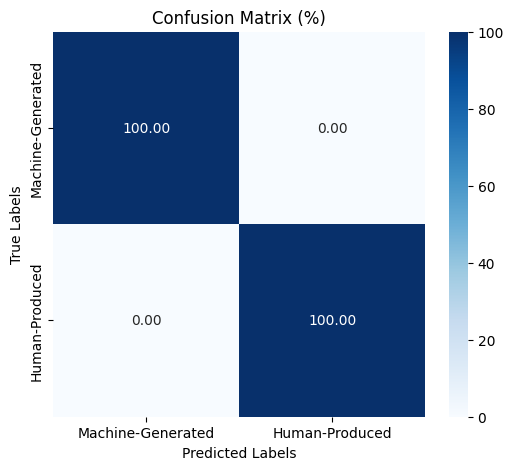

In [22]:
predicted_labels = df_test_dataset_llma.predicted_labels.to_list()
true_labels = df_test_dataset_llma.target_labels.to_list()
# Print unique values
print("Unique values in predicted_labels:", set(predicted_labels))
print("Unique values in true_labels:", set(true_labels))

# Calculate the confusion matrix with normalization
cm = confusion_matrix(true_labels, predicted_labels, labels=["machine-generated", "human-produced"], normalize='true')

# Convert confusion matrix to percentage
cm_percentage = cm * 100

# Print the confusion matrix
print("Confusion Matrix in Percentage:")
print(cm_percentage)

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Machine-Generated", "Human-Produced"], yticklabels=["Machine-Generated", "Human-Produced"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (%)')
plt.show()
